<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/One_Dimensional_VAE_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Painted Stones](https://github.com/yaniv256/VAEs-in-Economics/blob/master/Resources/PaintedStones.png?raw=true)

In [1]:
import tensorflow.keras as keras
keras.__version__

'2.2.4-tf'

## One Dimesional Variational Auto-Encoders

This notebook contains code for the One Dimensional VAE Workshop by Yaniv Ben-Ami. The code was developed from an example found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) by François Chollet and the reader is invited to check that out for details.


The particular type of neural network we’re going to set up is a one-dimensional Variational Auto-Encoder, VAE for short. VAEs are very simple and powerful, and you might have seen a demonstration of them encoding peoples’ faces or handwritten digits, or some other image data. In this notebook, you will learn how you can use VAEs to encode customer characteristics, or any other business data that isn’t an image. 

Customer data is the basis of market segmentation, and the encoding produced by the VAE will allow you to help your business better understand and serve its customers. You may have experience using clustering for customer segmentation, but as you might know, clustering can only handle a couple of variables. If you have more than 7-10 pieces of data about each customer, VAEs give you a solution to how you can use all of your data to its fullest potential. 

### Dimension reduction for customer insight

Our task is dimension reduction. The idea is that you have data that has lots of variables in it, but with so many variables it’s hard to understand what’s going on. You want to think about your customers, not as this huge spreadsheet with tens or hundreds of pieces of information about each customer, but as something simple. You want to think of just a couple of customer types, with the idea that you know people are not very different from those ideal types. 

Once you have someone’s type, you know almost everything you need to know from that huge dataset. The type gives you a good summary of the data that you’ve been collecting about the customer, but thanks to the VAE, it’s a simple description. For sure you’re going to lose some detail, but not much. And that simple description produced by the VAE is going to be super useful. Everyone in the business is going to be able to look at that type and immediately know the story of the customer. Instant insight.

I like to use the analogy of a lens. Before lenses were invented, we were severely limited in what we could observe with our eyes. Stars seemed indistinguishable from light fixtures on a celestial sphere. We couldn’t see that all life is made out of cells. That all life shares a common origin. The invention of lenses literally, but more importantly figuratively, changed how we view the world around us. By using telescopes, we can now see galaxies and black holes across the universe. Using microscopes, we regularly examine ourselves on a molecular level. Similarly, by using the lens of a VAE, we will be able to start observing a hidden aspect of our organizations’ data. The promise of the VAE is that once we observe these hidden types, we will gain a profoundly deeper understanding of our data’s underlying structure. 

Okay, so how does this kind of magic work? 

### A very good bottleneck
A one-dimensional VAE is a type of neural network that aims to condense the data into one number in a way that preserves as much detail as possible. The objective function for training the network is for it to give us back the same data that we put in with little or no distortion. Why do we do this? The neural network we use for this task has a very particular structure. It has a bottleneck hiding in the middle. This is the one time a bottleneck is a good thing. The bottleneck forces the neural network to find a low-dimensional encoding of all the patterns that exist in the data. If you make the bottleneck just one neuron, as I do, it will arrange the patterns along a continuum. As I will demonstrate, this will allow us to visualize the data in a way that would not be possible otherwise.

![Painted Stones](https://github.com/yaniv256/VAEs-in-Economics/blob/master/Resources/VAE.png?raw=true)

Once we complete training, we’re actually not going to be using the whole network. The useful part is the portion from the input to the bottleneck, and that’s it. This bit of the network is typically referred to as an “encoder.” We call it that because it “encodes” the complexity of the data in a simpler form. And that’s a beautiful thing.

VAEs allow you to dramatically decomplexify the data and make it as simple as possible. Once you make things simple, and identify good types to describe your clients, you can figure out what each type needs. For example, maybe you have a group of clients with low sales numbers. If you really understood that they are a different type than your common clients, you could study their special needs and design a product that addresses those needs specifically. 

Marketing professionals think this kind of micro-segmentation will change the world. How? Because in the future we will be tailoring products to narrower and narrower groups of customers. Continuously finding needs that were not recognized until detected by real-time algorithms processing incoming data. Coming out of this workshop, you will know how to do this.

### Preview of results

In this notebook, we’re going to apply the Variational Auto-Encoder (VAE) to two example public data sets. 

The first is the well-known Boston Housing data set. It's a small data set whose main advantage is that many data scientists are familiar with it, as it is often used for educational purposes.

The second data set is the American Time Use Survey (ATUS) data from 2013. It's a medium-scale data set whose main attraction is that it includes both data on time use and happiness, allowing a study of the link between the two.

In the ATUS, every entry documents 24 hours. We have the number of minutes spent by the respondent in each of the 389 activity categories. Our approach is that we’re going to use the VAE to identify simple types of American time use. We want to understand what types of days are out there and how many surveyed days belong to each type.

Here’s a preview of the distribution of types we get from computing a VAE on the 2013 ATUS data. 

The top left panel presents a histogram of how many respondents fell into each area of encoded space (we're using a rolling window). Interpreting what the encoding means requires us to use the decoder to uncover the character of time use that is typical for each bin, and this is what the colorful, lower-left panel is about. 

![Time use distribution](https://github.com/yaniv256/VAEs-in-Economics/blob/master/Resources/plot_dist_type.png?raw=true)

## Boston Housing


In [0]:
from tensorflow.keras import backend as K
K.clear_session()

### Data

#### Load the data

In [0]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#### Add labels and housing price data

In [4]:
import numpy as np
import pandas as pd

labels = ['CRIM - per capita crime rate by town', 
          'ZN - proportion of residential land zoned for lots over 25,000 sq.ft.',
          'INDUS - proportion of non-retail business acres per town',
          'CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
          'NOX - nitric oxides concentration (parts per 10 million)',
          'RM - average number of rooms per dwelling',
          'AGE - proportion of owner-occupied units built prior to 1940',
          'DIS - weighted distances to five Boston employment centres',
          'RAD - index of accessibility to radial highways',
          'TAX - full-value property-tax rate per $10,000',
          'PTRATIO - pupil-teacher ratio by town',
          'B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town',
          'LSTAT - % lower status of the population',
          'MEDV - Median value of owner-occupied homes in $1000\'s']

train_data = np.concatenate([train_data, train_targets.reshape((len(train_targets),1))], axis = 1)
test_data = np.concatenate([test_data, test_targets.reshape((len(test_targets),1))], axis = 1)
data = np.concatenate([train_data,test_data],axis=0)
data = pd.DataFrame(data, columns = labels)
data

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
502,0.07896,0.0,12.83,0.0,0.437,6.273,6.0,4.2515,5.0,398.0,18.7,394.92,6.78,24.1
503,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
504,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7


#### Transform to percentiles

In [5]:
from sklearn.preprocessing import QuantileTransformer

qt_trans = QuantileTransformer(n_quantiles=101, random_state=2)
qt_trans.fit(train_data)
qt = pd.DataFrame(qt_trans.transform(data))
qt.columns = labels
qt

,CRIM - per capita crime rate by town,"ZN - proportion of residential land zoned for lots over 25,000 sq.ft.",INDUS - proportion of non-retail business acres per town,CHAS - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),NOX - nitric oxides concentration (parts per 10 million),RM - average number of rooms per dwelling,AGE - proportion of owner-occupied units built prior to 1940,DIS - weighted distances to five Boston employment centres,RAD - index of accessibility to radial highways,"TAX - full-value property-tax rate per $10,000",PTRATIO - pupil-teacher ratio by town,B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,LSTAT - % lower status of the population,MEDV - Median value of owner-occupied homes in $1000's
0,0.676317,0.000,0.450000,0.0,0.510000,0.459433,0.693174,0.618406,0.280,0.425000,0.93,1.000000,0.829206,0.201216
1,0.038147,0.975,0.044131,0.0,0.078834,0.954588,0.031916,0.860000,0.070,0.526449,0.07,0.694930,0.028496,0.944661
2,0.790980,0.000,0.760000,0.0,0.750000,0.029960,1.000000,0.022964,1.000,0.865000,0.74,0.260637,0.036753,1.000000
3,0.107189,0.000,0.260000,0.0,0.430000,0.389518,0.164760,0.831271,0.505,0.075000,0.74,1.000000,0.318078,0.515000
4,0.751558,0.000,0.760000,0.0,0.890000,0.609602,0.630542,0.394235,1.000,0.865000,0.74,0.507947,0.649349,0.296667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.747431,0.000,0.760000,1.0,0.920000,1.000000,0.545660,0.195013,1.000,0.865000,0.74,0.181114,0.146124,0.557463
502,0.240501,0.000,0.600000,0.0,0.160000,0.546759,0.006284,0.659450,0.505,0.595000,0.47,0.668167,0.243929,0.713165
503,0.703974,0.000,0.915000,1.0,0.680000,0.963925,0.884274,0.237754,0.505,0.645000,0.07,0.442515,0.001650,1.000000
504,0.544350,0.000,0.330000,1.0,0.395000,0.856692,0.633005,0.456301,0.720,0.425000,0.27,0.514339,0.410963,0.783268


#### Train test split

In [6]:
x_train = qt[:len(train_data)]
x_test = qt[len(train_data):]
x_train.shape, x_test.shape

((404, 14), (102, 14))

### Network

#### Build the encoder

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow import set_random_seed
from numpy.random import seed

seed(42)
set_random_seed(42)

input_shape = (x_train.shape[1],)
latent_dim = 1  # Dimensionality of the latent space: a line
dense_width = 1024

input_x = keras.Input(shape=input_shape)

x = layers.Dense(dense_width, activation='relu')(input_x)
x = layers.Dense(dense_width, activation='relu')(x)
x = layers.Dense(dense_width, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

encoder = Model(input_x, z_mean)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Define the sampling layer

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)
Source: Deep Learning with Python 

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

#### Build the decoder

In [0]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(dense_width,activation='relu')(decoder_input)
x = layers.Dense(dense_width,activation='relu')(x)
x = layers.Dense(dense_width,activation='relu')(x)

x = layers.Dense(input_shape[0])(x)

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

#### Define the loss as a layer 

The loss is the sum of mean squared reconstruction error plus a regularization term that pushes the distribution of encoded data towards standard normal. To do so we compute the batch-level empirical Kullback-Leibler divergence from a standard normal and add it to the loss. See Wikipedia for details on the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions) from standard normal.

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        xent_loss = keras.metrics.mse(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_x, z_decoded])

vae = Model(input_x, y)

### Training

#### Train the network

In [11]:
vae.compile(optimizer='adam', loss=None)

n_batch_sizes=5

history =['']*n_batch_sizes
titles  =['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (reliable decrease in 
  # loss but weak and overfitting) and lots of epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 100*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))


Batch size: 512
Train on 404 samples, validate on 102 samples
Epoch 1/20
404/404 [==============================] - 1s 3ms/sample - loss: 0.3140 - val_loss: 0.2518
Epoch 2/20
404/404 [==============================] - 0s 25us/sample - loss: 0.2406 - val_loss: 0.1460
Epoch 3/20
404/404 [==============================] - 0s 23us/sample - loss: 0.1454 - val_loss: 0.2421
Epoch 4/20
404/404 [==============================] - 0s 21us/sample - loss: 0.2999 - val_loss: 0.1058
Epoch 5/20
404/404 [==============================] - 0s 19us/sample - loss: 0.1098 - val_loss: 0.1455
Epoch 6/20
404/404 [==============================] - 0s 21us/sample - loss: 0.1377 - val_loss: 0.1600
Epoch 7/20
404/404 [==============================] - 0s 20us/sample - loss: 0.1508 - val_loss: 0.1369
Epoch 8/20
404/404 [==============================] - 0s 20us/sample - loss: 0.1371 - val_loss: 0.1008
Epoch 9/20
404/404 [==============================] - 0s 21us/sample - loss: 0.1027 - val_loss: 0.0877
Epoch 10/20


#### Inspect convergence

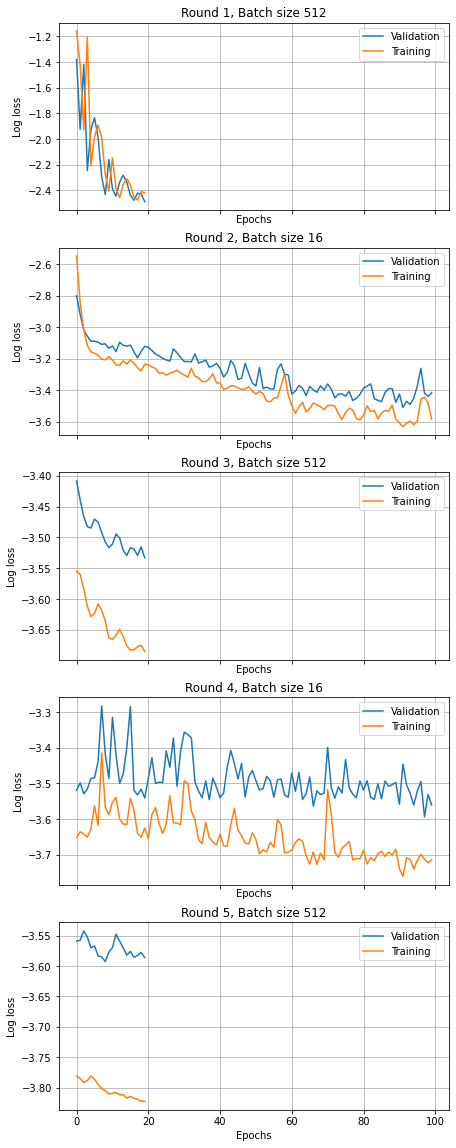

In [12]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()


### Results

#### Encode the data

In [13]:
encoded_data=encoder.predict(qt).flatten()
encoded_data.shape

(506,)

#### Generate types

In [14]:
min_x, max_x, grid_n = -2, 2, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=decoder.predict(grid_x)
decoded.shape

(401, 14)

#### Plot type distribution

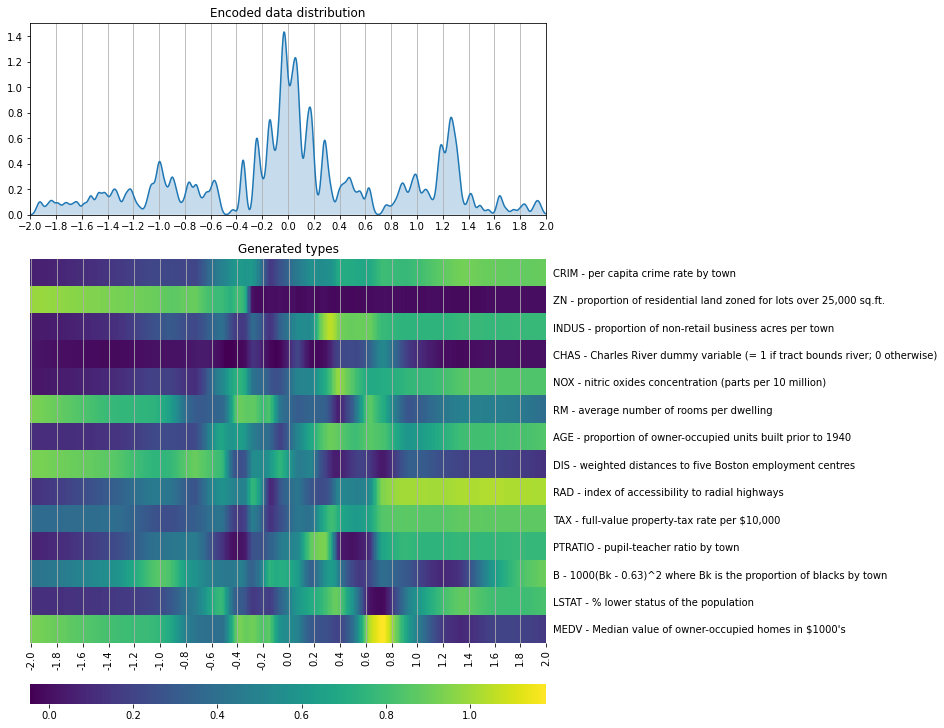

In [15]:
import seaborn as sns

fig = plt.figure(figsize=(13,10),constrained_layout=True)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

n_grid_lines=21
grid_lines = np.linspace(min_x,max_x,n_grid_lines)

ax1.set_title('Encoded data distribution')
sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
ax1.set_xticks( grid_lines )
ax1.set_xlim(min_x,max_x)
ax1.grid(axis='x')

ax2.set_title('Generated types')

sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
ax2.set_yticklabels(labels)
ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                left=False, labelrotation=0)
ax2.grid(axis='x')


## American Time Use

In [0]:
K.clear_session()

### Data

In [17]:
df=pd.read_csv("https://github.com/yaniv256/VAEs-in-Economics/blob/master/Data/Timeuse/time_shares_only_2013.csv?raw=true")
df

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,540,330,0,35,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,580,95,0,75,0,35,60,25,15,0,0,0,0,0,50,0,0,80,0,309,20,60,0,0,0,5,0,0,0,0,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,450,60,0,170,0,90,105,0,20,0,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0,0,0,0,0,0,40,0,145,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,450,65,680,70,0,30,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,570,90,0,120,0,0,60,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [18]:
qt_trans = QuantileTransformer(n_quantiles=1000, random_state=0)
qt = pd.DataFrame(qt_trans.fit_transform(df))
qt.columns = df.columns
qt

,Sleeping,Television_and_movies__not_religious_,Work__main_job,Eating_and_drinking,Socializing_and_communicating_with_others,Washing__dressing_and_grooming_oneself,Food_and_drink_preparation_,Interior_cleaning,Reading_for_personal_interest,Relaxing__thinking_,Shopping__except_groceries__food_and_gas,Travel_related_to_working,Playing_games,Laundry,Computer_use_for_leisure__exc__Games_,Lawn__garden__and_houseplant_care,Insufficient_detail_in_verbatim,Physical_care_for_hh_children,Attending_religious_services,Playing_with_hh_children__not_sports,Kitchen_and_food_clean_up,Grocery_shopping,Travel_related_to_eating_and_drinking,Research_homework_for_class_for_degree__certification__or_licensure,Travel_related_to_shopping__ex_groceries__food__and_gas,Household___personal_organization_and_planning,Taking_class_for_degree__certification__or_licensure,Travel_related_to_socializing_and_communicating,Health_related_self_care,Attending_or_hosting_parties_receptions_ceremonies,Work__other_job_s_,Gap_can_t_remember,Travel_related_to_caring_for___helping_hh_children,Sleeplessness,Travel_related_to_grocery_shopping,Walking,Care_for_animals_and_pets__not_veterinary_care_,Walking___exercising___playing_with_animals,Participation_in_religious_practices,Interior_arrangement__decoration____repairs,...,Travel_rel__to_socializing__relaxing____leisure__n_e_c__,Waiting_associated_w_banking_financial_services,Waiting_associated_w_admin__activities__education_,Travel_related_to_using_lawn_and_garden_services,Travel_related_to_nonhh_children_s_education,Waiting_associated_with_work_related_activities,Using_interior_cleaning_services_,Waiting_assoc__w_attending_hosting_social_events,Watching_rugby,Watching_skiing__ice_skating__snowboarding,Travel_related_to_personal_care__n_e_c__,Travel_related_to_education__n_e_c__,Travel_related_to_using_household_services__n_e_c__,Travel_related_to_work__n_e_c__,Travel_rel__to_religious_spiritual_activities__n_e_c__,Waiting_associated_w_purchasing_selling_real_estate,Waiting_associated_with_socializing__n_e_c__,Travel_related_to_consumer_purchases__n_e_c__,Security_procedures_related_to_work,Using_pet_services__n_e_c__,Telephone_calls_to_from_paid_child_or_adult_care_providers,Travel_related_to_using_legal_services,Lawn_and_garden__n_e_c___,Waiting_associated_with_research_homework,Waiting_associated_with_pet_services,Waiting_associated_with_other_income_generating_activities,Using_vehicle_maint____repair_svcs__n_e_c__,Housework__n_e_c___,Using_lawn_and_garden_services__n_e_c__,Security_procedures_rel__to_govt_svcs_civic_obligations__n_e_c__,Activities_related_to_nonhh_child_s_educ___n_e_c__,Waiting_associated_with_job_search_or_interview,Work_and_work_related_activities__n_e_c__,Government_services__n_e_c__,Public_health___safety_activities__n_e_c__,Travel_related_to_household_activities__n_e_c__,Travel_rel__to_govt_svcs___civic_obligations__n_e_c__,Food___drink_prep__presentation____clean_up__n_e_c___,Telephone_calls__n_e_c__,Public_health_activities
0,0.571572,0.831832,0.000000,0.304805,0.000000,0.311311,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.997387,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.693193,0.400901,0.000000,0.646146,0.000000,0.508008,0.825325,0.782282,0.791792,0.000000,0.0,0.000000,0.000000,0.000000,0.919920,0.0,0.000000,0.961962,0.0,0.995862,0.851852,0.958458,0.000000,0.000000,0.0,0.871371,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.877878,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.262262,0.304304,0.000000,0.958959,0.000000,0.903403,0.937437,0.000000,

In [0]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(qt, test_size=0.33, random_state=42)

### Network

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

def make_vae(input_shape):

  latent_dim = 1  
  dense_width = 1024

  input_x = keras.Input(shape=input_shape)

  x = layers.Dense(dense_width, activation='relu')(input_x)
  x = layers.Dense(dense_width, activation='relu')(x)
  x = layers.Dense(dense_width, activation='relu')(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)

  encoder = Model(input_x, z_mean)

  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])

  # Upsample to the correct number of units
  x = layers.Dense(dense_width,activation='relu')(decoder_input)
  x = layers.Dense(dense_width,activation='relu')(x)
  x = layers.Dense(dense_width,activation='relu')(x)

  x = layers.Dense(input_shape[0])(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  class CustomVariationalLayer(keras.layers.Layer):

      def vae_loss(self, x, z_decoded):
          xent_loss = keras.metrics.mse(x, z_decoded)
          kl_loss = -5e-4 * K.mean(
              1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
          return K.mean(xent_loss + kl_loss)

      def call(self, inputs):
          x = inputs[0]
          z_decoded = inputs[1]
          loss = self.vae_loss(x, z_decoded)
          self.add_loss(loss, inputs=inputs)
          # We don't use this output.
          return x

  # We call our custom layer on the input and the decoded output,
  # to obtain the final model output.
  y = CustomVariationalLayer()([input_x, z_decoded])

  vae = Model(input_x, y)
  vae.encoder = encoder
  vae.decoder = decoder

  return vae

### Training

In [21]:
from tensorflow import set_random_seed
from numpy.random import seed

seed(42)
set_random_seed(42)

vae = make_vae(input_shape=(x_train.shape[1],))

vae.compile(optimizer='adam', loss=None)

n_batch_sizes=9

history = ['']*n_batch_sizes
titles  = ['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (realiable decrease in 
  # loss but weak and overfitting) and a few epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 4096*(1-(i%2)) + 64*(i%2)
  epochs = 50*(1-(i%2)) + 50*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))

Batch size: 4096
Train on 7627 samples, validate on 3758 samples
Epoch 1/50
7627/7627 [==============================] - 1s 75us/sample - loss: 0.0205 - val_loss: 0.0194
Epoch 2/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0188 - val_loss: 0.0179
Epoch 3/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0176 - val_loss: 0.0172
Epoch 4/50
7627/7627 [==============================] - 0s 12us/sample - loss: 0.0170 - val_loss: 0.0169
Epoch 5/50
7627/7627 [==============================] - 0s 11us/sample - loss: 0.0167 - val_loss: 0.0166
Epoch 6/50
7627/7627 [==============================] - 0s 11us/sample - loss: 0.0164 - val_loss: 0.0163
Epoch 7/50
7627/7627 [==============================] - 0s 11us/sample - loss: 0.0161 - val_loss: 0.0161
Epoch 8/50
7627/7627 [==============================] - 0s 11us/sample - loss: 0.0159 - val_loss: 0.0160
Epoch 9/50
7627/7627 [==============================] - 0s 11us/sample - loss: 0.0159 - val_los

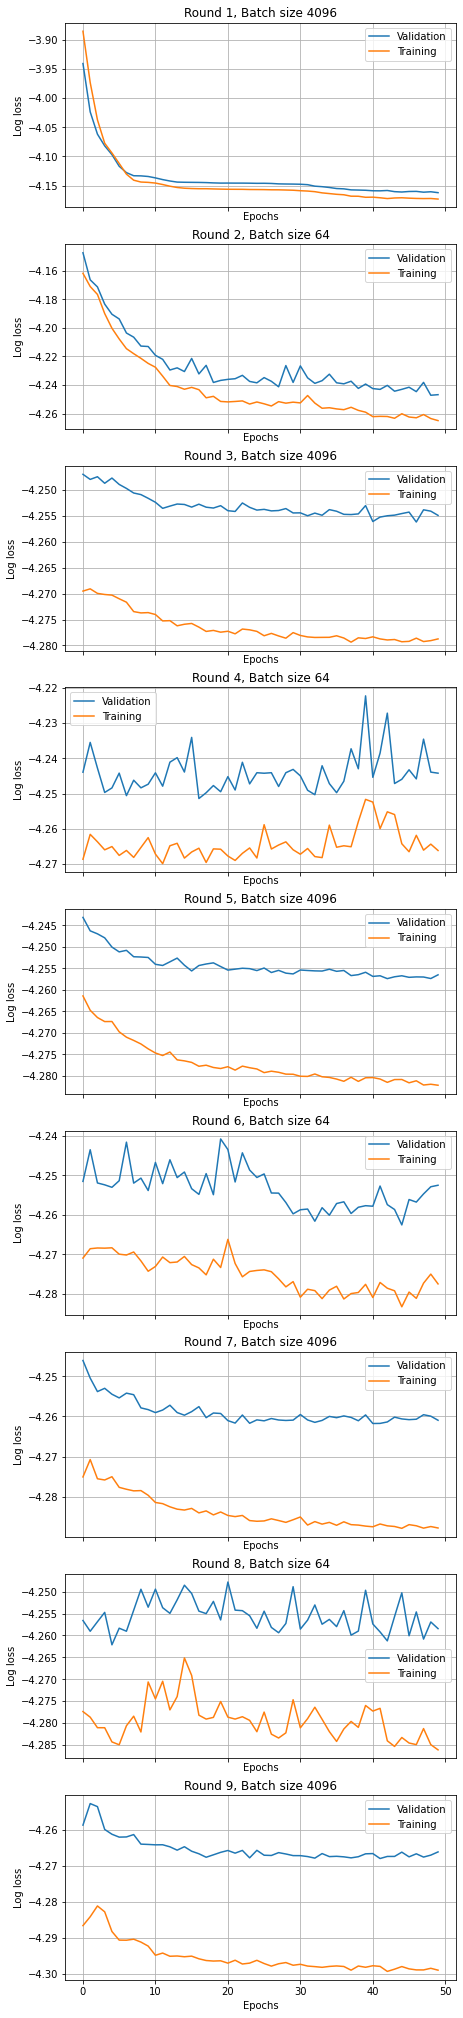

In [22]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()

### Results

#### Time use distribution

In [23]:
encoded_data=vae.encoder.predict(qt).flatten()
encoded_data.shape

(11385,)

In [24]:
min_x, max_x, grid_n = -2, 2, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=vae.decoder.predict(grid_x)
decoded.shape

(401, 389)

In [0]:
import seaborn as sns

def plot_type_dist(encoded_data, grid_x, decoded, vertical_n, type_labels):

  fig = plt.figure(figsize=(13,vertical_n*2.5),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  n_grid_lines=21
  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(type_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

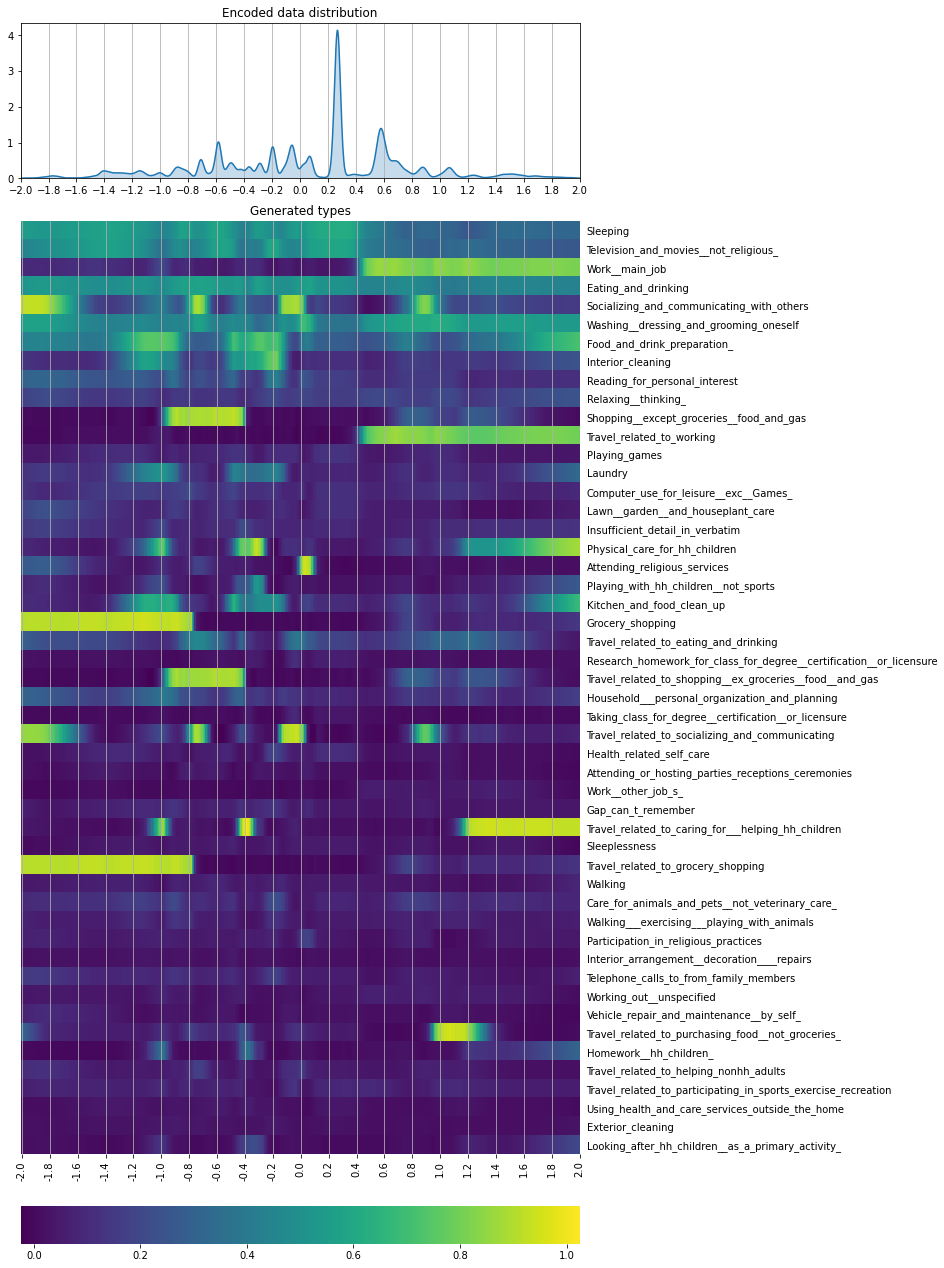

In [26]:
plot_type_dist(encoded_data, grid_x, decoded[:,:50], 
               vertical_n=7, type_labels=qt.columns[:50])

plt.savefig('plot_dist_type.png')

#### Gender

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Data/Timeuse/atussum_2013/atussum_2013.dat')
df

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,TEMJOT,TRDPFTPT,TESCHENR,TESCHLVL,TRSPPRES,TESPEMPNOT,TRERNWA,TRCHILDNUM,TRSPFTPT,TEHRUSLT,TUDIARYDAY,TRHOLIDAY,TRTEC,TRTHH,t010101,t010102,t010201,t010299,t010301,t010399,t010401,t020101,t020102,t020103,t020104,t020199,t020201,t020202,t020203,t020299,...,t180704,t180799,t180801,t180802,t180803,t180804,t180805,t180806,t180807,t180899,t180901,t180902,t180903,t180904,t180905,t180999,t181001,t181002,t181099,t181101,t181201,t181202,t181203,t181204,t181205,t181299,t181301,t181302,t181401,t181499,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,1.189991e+07,12,22,2,40,8,2,1,5,-1,-1,1,2,3,-1,-1,3,-1,-1,1,0,-1,365,540,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4.447638e+06,1,39,1,43,1,2,1,1,2,1,2,-1,1,1,173076,1,2,40,1,0,-1,296,580,0,35,0,0,0,0,25,0,0,0,0,60,0,20,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20130101130123,1.037706e+07,-1,47,2,40,1,2,1,4,-1,-1,2,-1,1,1,-1,0,3,-1,2,0,-1,0,450,0,90,0,0,0,0,0,0,0,0,0,105,30,15,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7.731258e+06,-1,50,2,40,1,1,1,1,2,1,-1,-1,3,-1,86538,0,-1,-4,3,0,-1,0,450,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4.725269e+06,-1,45,2,40,2,2,1,1,1,2,1,2,3,-1,23000,0,-1,21,2,0,-1,0,570,0,0,0,0,0,0,0,30,0,0,0,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11380,20131212132458,4.469644e+06,-1,85,2,44,1,2,1,5,-1,-1,-1,-1,3,-1,-1,0,-1,-1,2,0,-1,0,450,0,15,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11381,20131212132462,4.103677e+06,-1,60,1,39,1,1,1,1,2,1,-1,-1,1,2,61538,0,-1,40,1,0,-1,0,455,0,75,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11382,20131212132469,2.355797e+07,9,43,1,39,1,1,1,1,2,1,2,-1,1,1,80000,2,1,40,5,0,-1,77,645,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11383,20131212132475,2.045005e+07,16,48,1,39,1,2,1,1,2,1,2,-1,1,1,66000,1,1,40,4,1,-1,0,510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,0,0,0,0


In [28]:
Female = (df['TESEX'] == 2)
encoded_data[Female].shape , encoded_data[Female == False].shape

((6303,), (5082,))

In [0]:
def plot_type_dist_list(encoded_data_list, grid_x, decoded, 
                        type_labels, vertical_n, dist_labels):

  fig = plt.figure(figsize=(13,vertical_n*2.5),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  n_grid_lines=21
  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  for i in range(len(encoded_data_list)):
    sns.kdeplot(encoded_data_list[i],bw=0.02, shade = True, 
                ax=ax1, gridsize=2000, label=dist_labels[i])
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(type_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

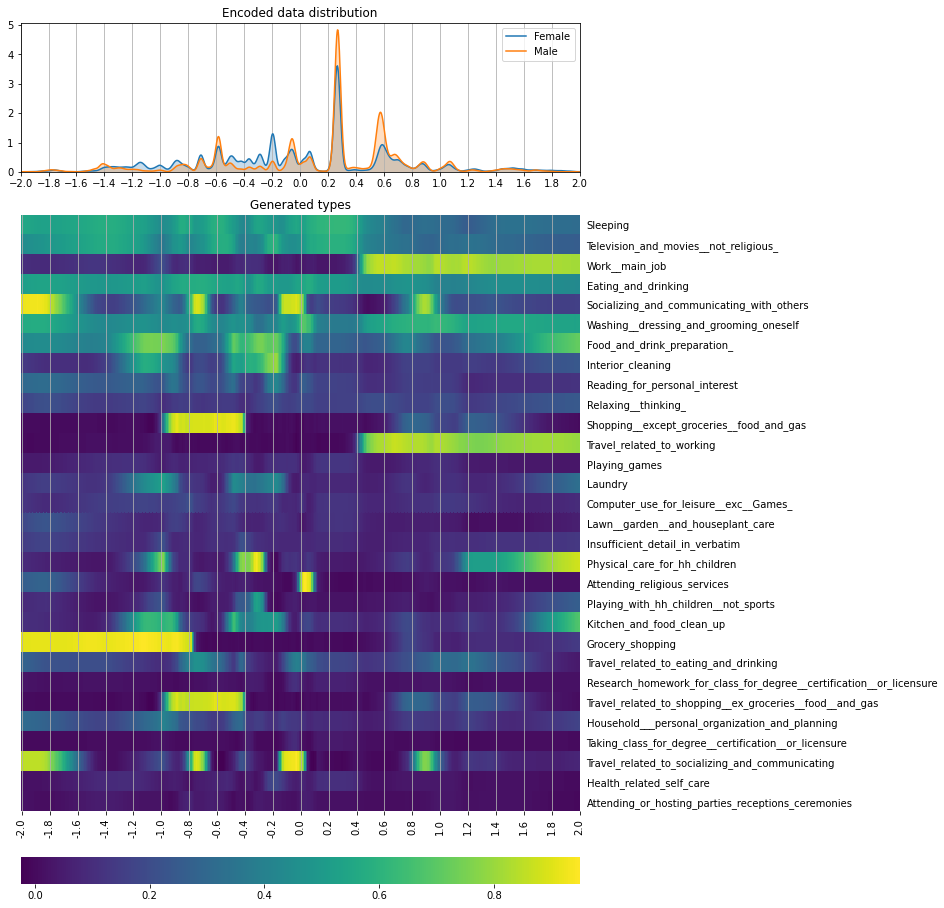

In [30]:
plot_type_dist_list([encoded_data[Female], encoded_data[Female == False]], 
                    grid_x, decoded[:,:30], 
                    type_labels=qt.columns[:30], vertical_n=5,
                    dist_labels = ['Female', 'Male'])

#### Employment

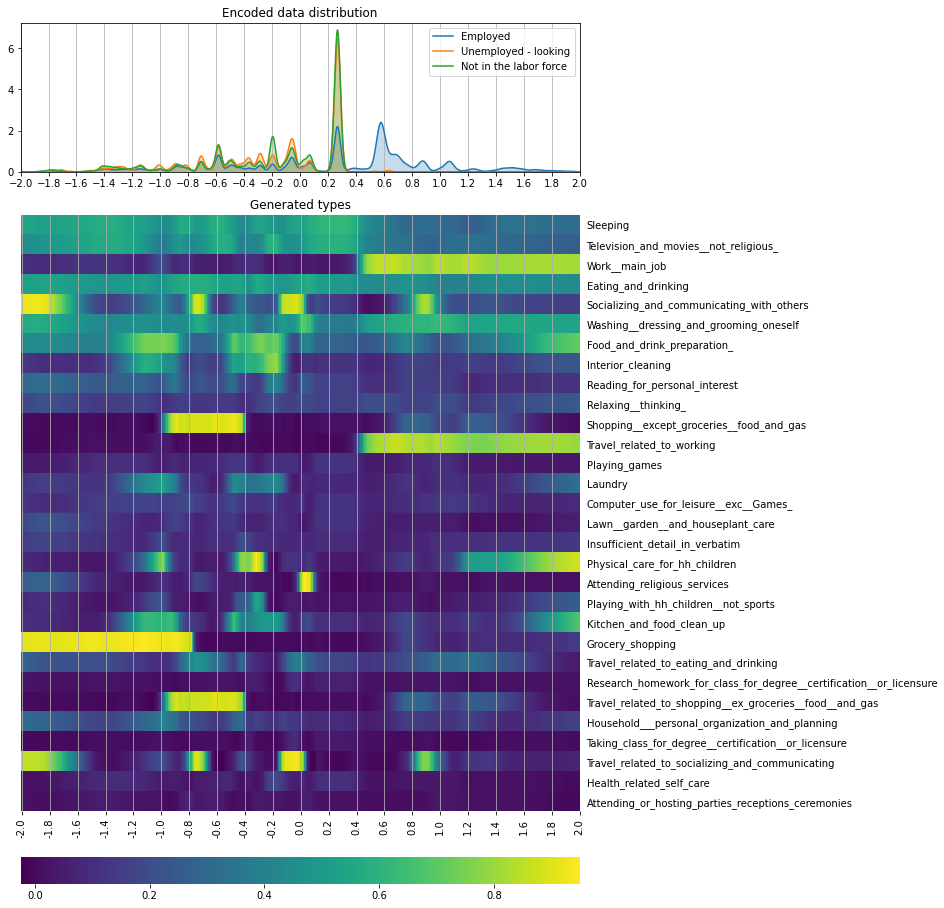

In [31]:
Employed = df['TELFS'] == 1
UnemployedLooking = df['TELFS'] == 4
NotInTheLaborForce = df['TELFS'] == 5

plot_type_dist_list([encoded_data[Employed], 
                     encoded_data[UnemployedLooking],
                     encoded_data[NotInTheLaborForce] 
                     ], 
                    grid_x, decoded[:,:30], 
                    type_labels=qt.columns[:30], vertical_n=5,
                    dist_labels = ['Employed', 
                                   'Unemployed - looking', 
                                   'Not in the labor force'])

#### Children

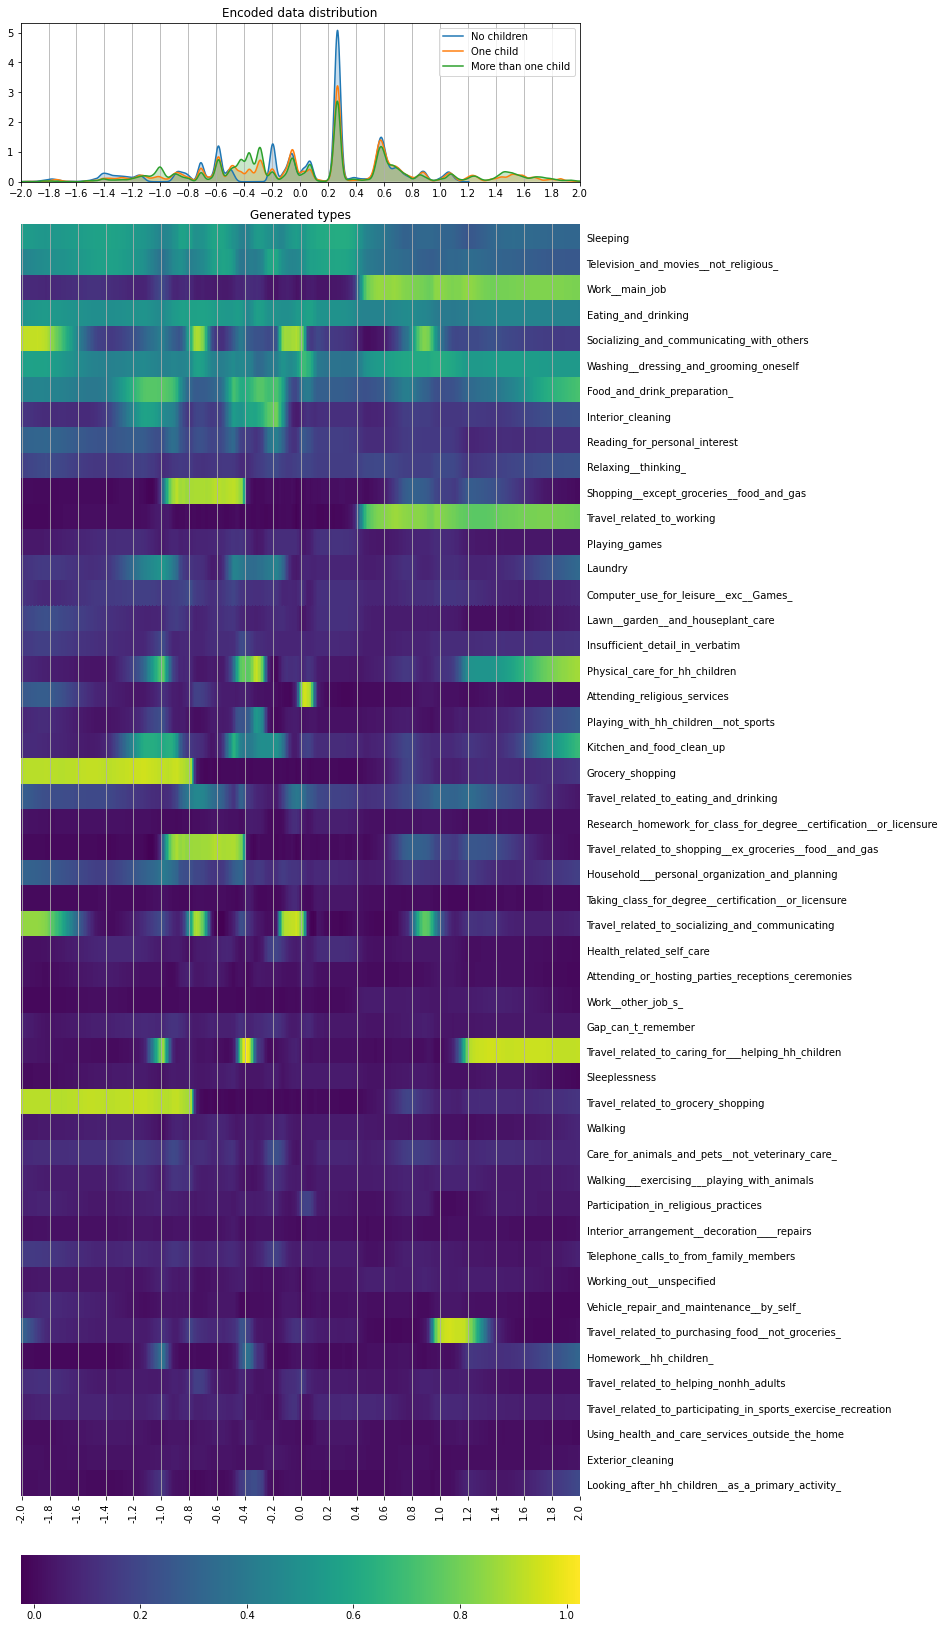

In [32]:
plot_type_dist_list([encoded_data[df['TRCHILDNUM'] == 0 ], 
                     encoded_data[df['TRCHILDNUM'] == 1],
                     encoded_data[df['TRCHILDNUM'] > 1] 
                     ], 
                    grid_x, decoded[:,:50], 
                    type_labels=qt.columns[:50], vertical_n=9,
                    dist_labels = ['No children', 
                                   'One child', 
                                   'More than one child'])

#### Happiness

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Data/Timeuse/atussum_2013/atussum_2013.dat',index_col=0)
print(df.shape)

df2 = pd.read_csv('https://raw.githubusercontent.com/yaniv256/VAEs-in-Economics/master/Data/Timeuse/wbresp_2013/wbresp_2013.dat',index_col=0)
print(df2.shape)

df = df.join(df2)
print(df.shape)

(11385, 412)
(10378, 15)
(11385, 427)


In [34]:
(encoded_data[df["WECANTRIL"] < 4].shape,
 encoded_data[df["WECANTRIL"] == 4].shape, 
 encoded_data[df["WECANTRIL"] == 10].shape)

((493,), (387,), (1451,))

"Please imagine a ladder with steps numbered from 0 at the bottom
to 10 at the top. The top of the ladder represents the best possible life for
you and the bottom of the ladder represents the worst possible life for you.
If the top step is 10 and the bottom step is 0, on which step of the ladder
do you feel you personally stand at the present time?"

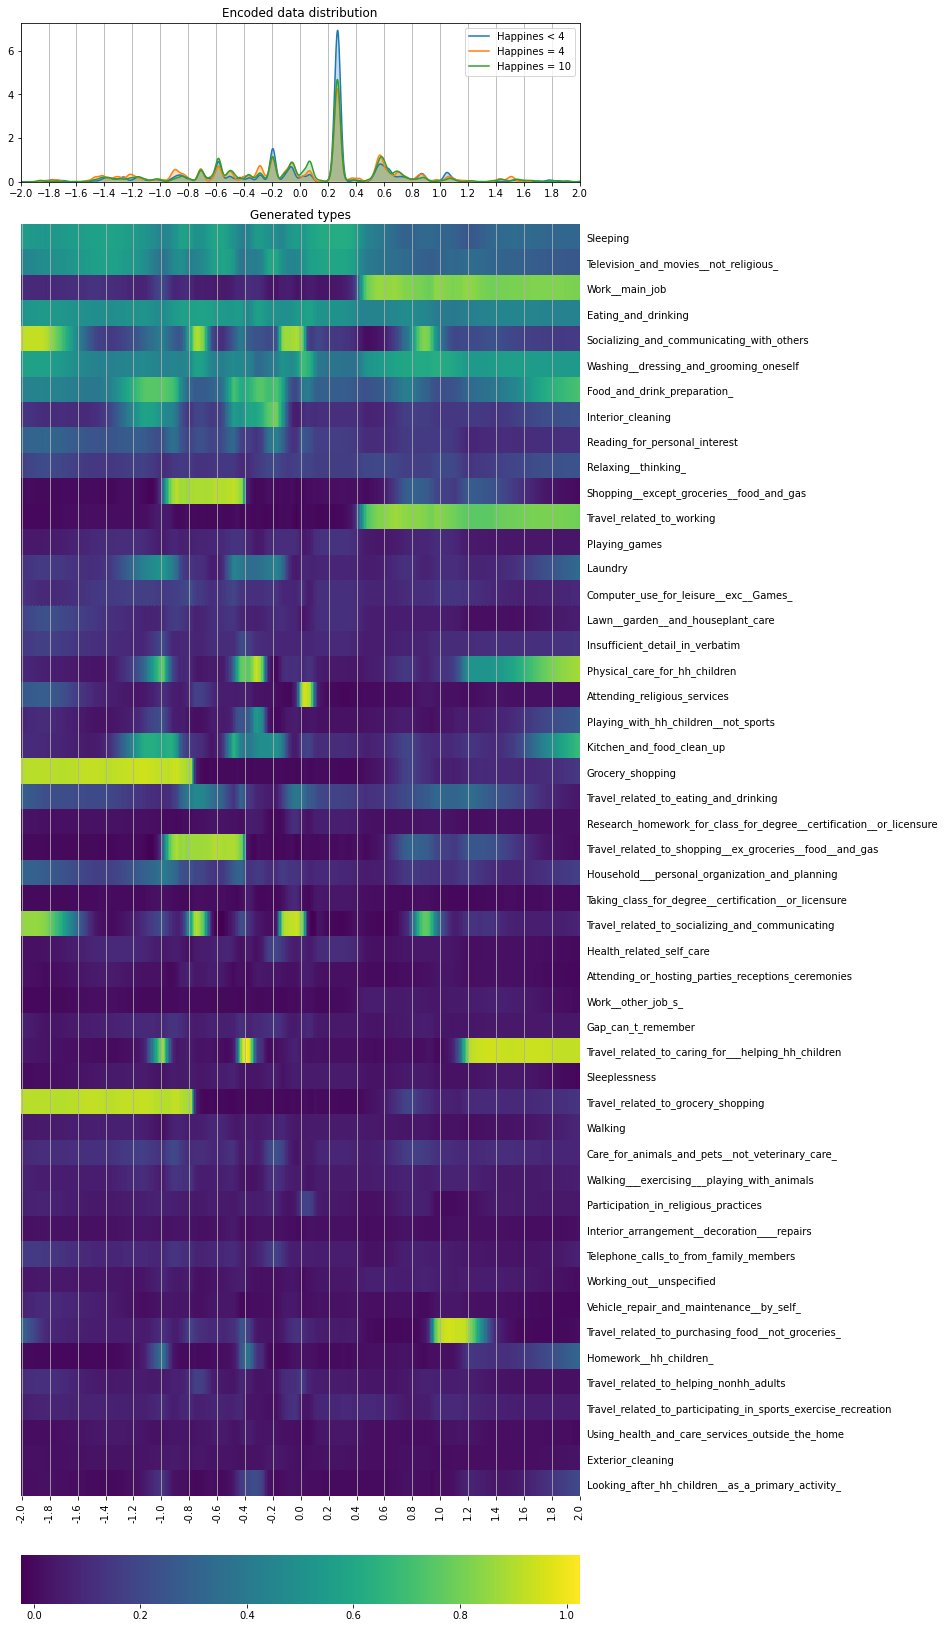

In [35]:
plot_type_dist_list([encoded_data[df["WECANTRIL"] < 4 ], 
                     encoded_data[df["WECANTRIL"] == 4],
                     encoded_data[df["WECANTRIL"] == 10]
                     ], 
                    grid_x, decoded[:,:50], 
                    type_labels=qt.columns[:50], vertical_n=9,
                    dist_labels = ['Happines < 4', 
                                   'Happines = 4',
                                   'Happines = 10'])

"Thinking about yesterday as a whole, how would you say your feelings, both good and bad, compared to a typical \[FILL= DAY]? Were
they better than a typical \[FILL=DAY], the same as a typical \[FILL=DAY],
or worse than a typical \[FILL=DAY]?"

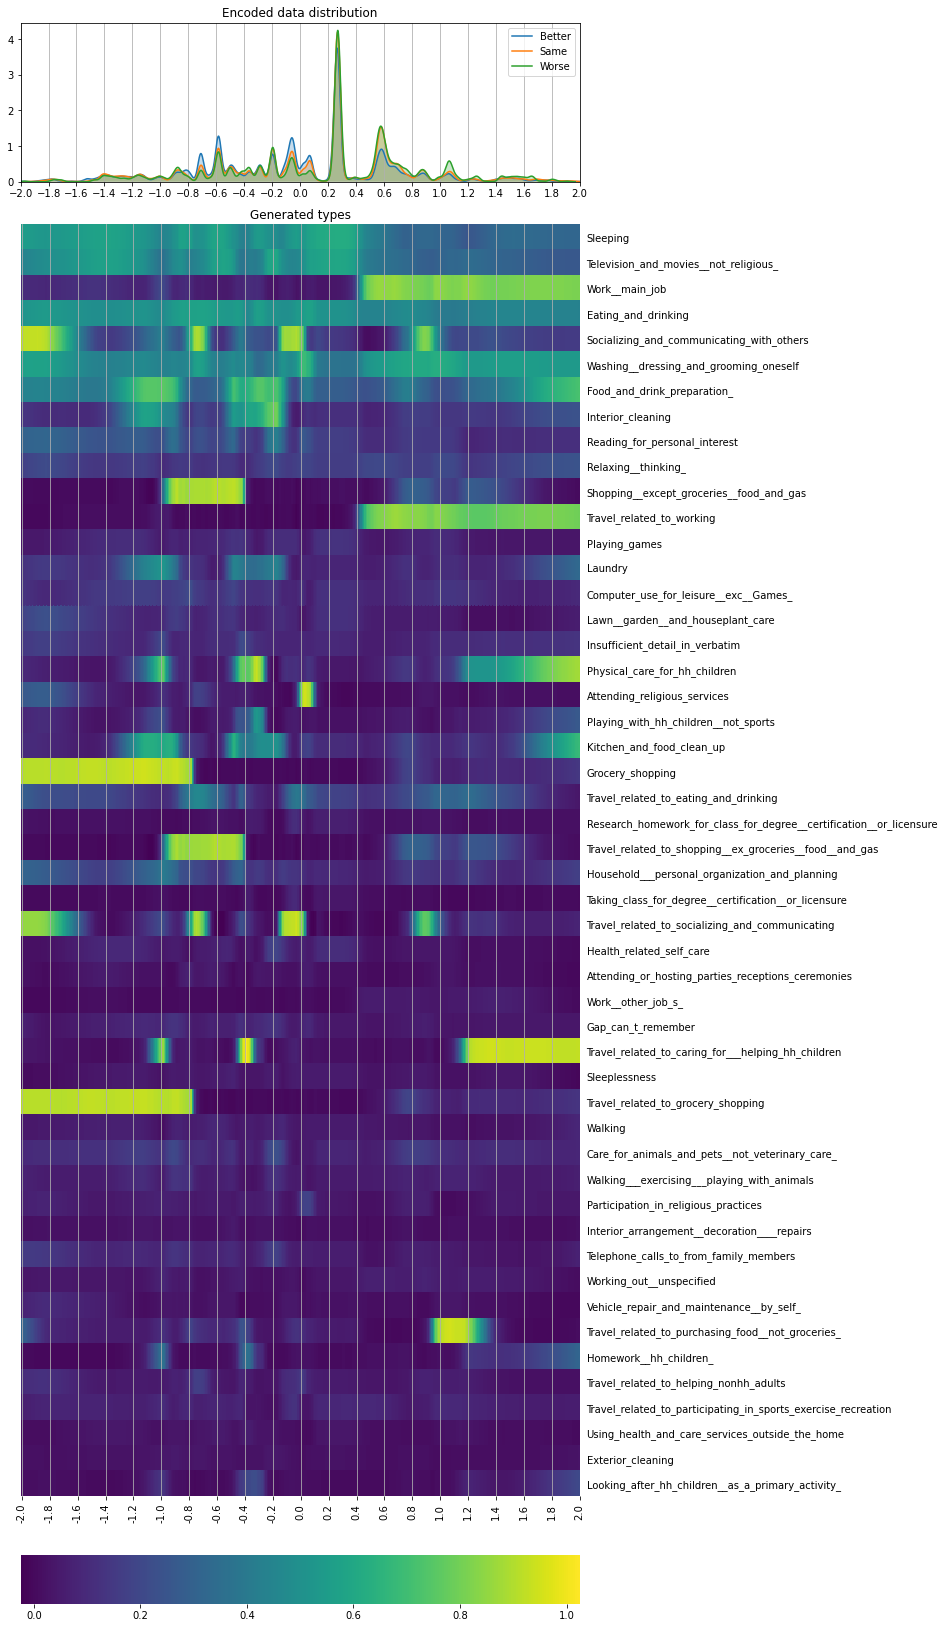

In [36]:
plot_type_dist_list([encoded_data[df["WETYPICAL"] == 1], 
                     encoded_data[df["WETYPICAL"] == 2],
                     encoded_data[df["WETYPICAL"] == 3]
                     ], 
                    grid_x, decoded[:,:50], 
                    type_labels=qt.columns[:50], vertical_n=9,
                    dist_labels = ['Better', 
                                   'Same',
                                   'Worse'])